In [0]:
#@title ##### License
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Explore the Darwin's Community graphs

In [36]:
#@title ### Install the Graph Nets library on this Colaboratory runtime  { form-width: "60%", run: "auto"}
#@markdown <br>1. Connect to a local or hosted Colaboratory runtime by clicking the **Connect** button at the top-right.<br>2. Choose "Yes" below to install the Graph Nets library on the runtime machine with:<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;```pip install graph_nets```<br> Note, this works both with local and hosted Colaboratory runtimes.

install_graph_nets_library = "Yes"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library with:")
  print("  $ pip install graph_nets\n")
  print("Output message from command:\n")
  !pip install graph_nets
else:
  print("Skipping installation of Graph Nets library")

Installing Graph Nets library with:
  $ pip install graph_nets

Output message from command:



### Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy
```

# Code

In [0]:
#@title Imports  { form-width: "20%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [0]:
#@title Darwin's Surfaces { form-width: "20%" }
from scipy.spatial import Delaunay
import numpy as np
from numpy import sin, cos, sqrt
import matplotlib.tri as mtri
from sklearn import preprocessing
import mpl_toolkits.mplot3d as plt3d
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.switch_backend('agg')

import time
np.random.seed(seed=int(time.time()))
#np.random.seed(123) #default seed = 7
eps = 1e-7

SURFACE_TYPES = [
    'elliptic_paraboloid',
    'saddle',
    'torus',
    'ellipsoid',
    'elliptic_hyperboloid',
    'another'
]


def feature_standardization(X):
    '''set_feature.shape: (-1,N,dim)'''
    std_feature = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    for i in range(X.shape[0]):
        std_feature[i] = (X[i]-np.min(X[i]))/(np.max(X[i])-np.min(X[i]))

    return std_feature

class SurfaceNumpyGenerator:
    '''function surface from http://mathworld.wolfram.com/AlgebraicSurface.html'''

    def __init__(self, num_surfaces, num_points):
        self.num_surfaces = num_surfaces
        self.num_points = num_points

    def saddle_func(self, a, b, h, num_points):
        '''hyperbolic parabolid z = y^2/b^2 - x^2/a^2'''
        n = int(sqrt(num_points))
        x = np.linspace(-n/4, n/4, n)
        y = np.linspace(-n/4, n/4, n)
        x, y = np.meshgrid(x, y)
        z = h * ((y**2/b**2) - (x**2/a**2))
        points2D = np.vstack([x.flatten(), y.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def elliptic_paraboloid_func(self, a, b, c, num_points):
        '''x=x^2/a^2 + y^2/b^2 = z/c'''
        n = int(sqrt(num_points))
        x = np.linspace(-n/4, n/4, n)
        y = np.linspace(-n/4, n/4, n)
        x, y = np.meshgrid(x, y)
        z = c * ((x**2/a**2) + (y**2/b**2))
        points2D = np.vstack([x.flatten(), y.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def cone_func(self, h, r, num_points):
        '''x=((h-u)/h)*r*cos(theta), y=((h-u)/h)*r*sin(theta), z=u'''
        n = int(sqrt(num_points))
        #theta = np.linspace(0, 2*np.pi, n)
        #u = np.linspace(0, h, n)
        #theta, u = np.meshgrid(theta, u)
        #x =  ( (h - u)/h ) * r * cos(theta)
        #y =  ( (h - u)/h ) * r * sin(theta)
        #z = u
        u = np.linspace(-np.pi, np.pi, n)
        v = np.linspace(-np.pi, np.pi, n)
        u, v = np.meshgrid(u,v)

        x = ( (h - u)/h )*np.cos(v)
        y = ( (h - u)/h )*np.sin(v)
        z = u
        #points2D = np.vstack([u.flatten(), theta.flatten()]).T
        points2D = np.vstack([x.flatten(), y.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def elliptic_hyperboloid_func(self, a, b, c, num_points):
        '''x^2/a^2 + y^2/b^2 - z^2/c^2 = 1'''
        n = int(sqrt(num_points))
        u=np.linspace(-4.0,4.0,n);
        v=np.linspace(0, 2*np.pi,n);
        u, v = np.meshgrid(u, v)
        x = a * np.cosh(u) * cos(v)
        y = b * np.cosh(u) * sin(v)
        z = c * np.sinh(u)
        points2D = np.vstack([u.flatten(), v.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def torus_func(self, r, R, num_points):
        '''x=(c+a*cos(u))*cos(v), y=(c+a*cos(v))*sin(u), z=a*sin(v)'''
        n = int(sqrt(num_points))
        u = np.linspace(0, 2 * np.pi, n)
        v = np.linspace(0, 2 * np.pi, n)
        u, v = np.meshgrid(u, v)
        x = (R + r * cos(v)) * np.cos(u)
        y = (R + r * cos(v)) * np.sin(u)
        z = r * np.sin(v)
        points2D = np.vstack([u.flatten(), v.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def cylinder_func(self, r, h, num_points):
        '''x=r*cos(theta), y=r*sin(theta), z=z'''
        n = int(sqrt(num_points))
        z = np.linspace(0, h, n)
        theta = np.linspace(0, 2*np.pi, n)
        theta, z  = np.meshgrid(theta, z)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        points2D = np.vstack([z.flatten(), theta.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def ellipsoid_func(self, a, b, c, num_points):
        '''x=a*cos(u)*sin(v), y=b*sin(u)*sin(v), z=c*cos(v)'''
        n = int(sqrt(num_points))
        v = np.linspace(0, np.pi, n)
        u = np.linspace(0, 2*np.pi, n)
        u, v = np.meshgrid(u, v)
        x = a * cos(u) * sin(v)
        y = b * sin(u) * sin(v)
        z = c * cos(v)
        points2D = np.vstack([u.flatten(), v.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def ding_dong_func(self, r, h, num_points):
        ''' as '''
        n = int(sqrt(num_points))
        u = np.linspace(0, 2*np.pi, n)
        v = np.linspace(-h, 1, n)
        u, v = np.meshgrid(u, v)
        x = r * v * sqrt(1 - v) * cos(u)
        y = r * v * sqrt(1 - v) * sin(u)
        z = r * v
        points2D = np.vstack([u.flatten(), v.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri


    #http://mathworld.wolfram.com/HyperbolicCylinder.html
    #http://mathworld.wolfram.com/Ding-DongSurface.html
    #http://mathworld.wolfram.com/WhitneyUmbrella.html


    def another_func(self, h, num_points):
        '''cos(abs(x)+abs(y))*(abs(x)+abs(y))'''
        n = int(sqrt(num_points))
        #x = np.arange(-n/4., n/4., 0.5)
        #y = np.arange(-n/4., n/4., 0.5)
        x = np.linspace(-10, 10, n)
        y = np.linspace(-10, 10, n)
        x, y = np.meshgrid(x, y)
        #z = cos(abs(x)+abs(y))*(abs(x)+abs(y))
        z = h * sin(sqrt(x**2 + y**2))
        points2D = np.vstack([x.flatten(), y.flatten()]).T
        tri = Delaunay(points2D).simplices
        return x.flatten(), y.flatten(), z.flatten(), tri

    def transform_translate(self, mtrx, tx, ty, tz):
        '''mtrx.shape(3,3), [xs, ys, zs].T'''
        #convert to homogeneous coord
        mtrx = np.concatenate((mtrx,np.ones((1,mtrx.shape[1]))),axis=0)
        #T matrix transform
        T = np.identity(4)
        T[0][3] = tx
        T[1][3] = ty
        T[2][3] = tz
        #return euclidean coord
        return np.dot(T, mtrx)[:3,:]

    def transform_scale(self, mtrx, sx, sy, sz):
        '''mtrx.shape(3,3), [xs, ys, zs].T'''
        #convert to homogeneous coord
        mtrx = np.concatenate((mtrx,np.ones((1,mtrx.shape[1]))),axis=0)
        #T matrix transform
        T = np.identity(4)
        T[0][0] = sx
        T[1][1] = sy
        T[2][2] = sz
        #return euclidean coord
        return np.dot(T, mtrx)[:3,:]

    def transform_rotate(self, mtrx, alpha, beta, gamma):
        '''mtrx.shape(3,3), [xs, ys, zs].T
             alpha, beta, gamma: angles in radias 90°=1.5708, 180°=3.14159, 270°=4.71239, 360°=6.28319
             alpha: rotate axis x, beta: rotate axis y, gamma: rotate axis z'''
        #get means of xs, ys, zs
        mean_tx = np.mean(mtrx[0])
        mean_ty = np.mean(mtrx[1])
        mean_tz = np.mean(mtrx[2])
        #translate to center axis
        mtrx = self.transform_translate(mtrx, -mean_tx, -mean_ty, -mean_tz)
        #convert to homogeneous coord
        mtrx = np.concatenate((mtrx,np.ones((1,mtrx.shape[1]))),axis=0)
        #T matrix transform
        T = np.identity(4)
        T[0][0]=cos(beta)*cos(gamma); T[0][1]=sin(alpha)*sin(beta)*cos(gamma) - cos(alpha)*sin(gamma);
        T[0][2]=cos(alpha)*sin(beta)*cos(gamma) + sin(alpha)*sin(gamma)
        T[1][0]=cos(beta)*sin(gamma); T[1][1]=sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma)
        T[1][2]=cos(alpha)*sin(beta)*sin(gamma) - sin(alpha)*cos(gamma)
        T[2][0]=-sin(beta); T[2][1]=sin(alpha)*cos(beta)
        T[2][2]=cos(alpha)*cos(beta)
        #euclidean coord
        mtrx = np.dot(T, mtrx)[:3,:]
        #back to original position
        return self.transform_translate(mtrx, mean_tx, mean_ty, mean_tz)

    def transform_reflex(self, mtrx, xy, xz, yz):
        '''mtrx.shape(3,3), [xs, ys, zs].T
        reflex the axis xy, xz, yz, boolean'''
        #convert to homogeneous coord
        mtrx = np.concatenate((mtrx,np.ones((1,mtrx.shape[1]))),axis=0)
        #T matrix transform
        T = np.identity(4)
        if xy:
            T[2][2] = -1.0
        if xz:
            T[1][1] = -1.0
        if yz:
            T[0][0] = -1.0
        #return euclidean coord
        return np.dot(T, mtrx)[:3,:]

    def transformation_shear(self, mtrx, xy, xz, yz, ca=0., cb=0.,cc=0., cd=0., ce=0., cf=0.):
        '''mtrx.shape(3,3), [xs, ys, zs].T
        shear on plane xy(ca, cb), on plane xz(cc,cd), and yz(ce, cf)'''
        #convert to homogeneous coord
        mtrx = np.concatenate((mtrx,np.ones((1,mtrx.shape[1]))),axis=0)
        #T matrix transform
        T = np.identity(4)
        if xy:
            T[0][2] = ca
            T[1][2] = cb
        if xz:
            T[0][1] = cc
            T[2][1] = cd
        if yz:
            T[1][0] = ce
            T[2][0] = cf
        #return euclidean coord
        return np.dot(T, mtrx)[:3,:]

    def generate_func(self, surface_type, num_surfaces, num_perm):
        list_point_features = []
        list_adj = []
        num_perm -= 1 # because the first object dont has permutation
        #list_point_features_perm = []
        #list_adj_perm = []
        #list_point_features = np.zeros((num_surfaces,self.num_points,3))
        #list_adj = np.zeros((num_surfaces,self.num_points,self.num_points))
        print("dataset " + surface_type)

        for i in range(num_surfaces):
            #create surface points
            if surface_type == 'elliptic_paraboloid':
                a, b = np.random.uniform(low=1.0, high=3.0, size=(2))
                c = np.random.uniform(low=3.0, high=7.0, size=(1))
                #print("a, b: ", a, b)
                x,y,z,tri = self.elliptic_paraboloid_func(a=a, b=b, c=c, num_points=self.num_points)
            elif surface_type == 'cone':
                h = np.random.uniform(low=3.0, high=7.0, size=(1))
                r = np.random.uniform(low=1.0, high=4.0, size=(1))
                x,y,z,tri = self.cone_func(h=h, r=r, num_points=self.num_points)
                #a, b = np.random.uniform(low=1.0, high=3.0, size=(2))
                #c = np.random.uniform(low=4.0, high=7.0, size=(1))
                #print("a, b: ", a, b)
                #x,y,z,tri = self.cone_func(a=a, b=b, c=c, num_points=self.num_points)
            elif surface_type == 'saddle':
                #a, b = np.random.random(2)*10+1.0
                a, b = np.random.uniform(low=0.5, high=3.0, size=(2))
                a = -a if (np.random.randint(2) > 0) else a
                b = -b if (np.random.randint(2) > 0) else b
                h = np.random.uniform(low=3.0, high=8.0, size=(1))
                #print("a, b: ", a, b)
                x,y,z,tri = self.saddle_func(a=a, b=b, h=h, num_points=self.num_points)
            elif surface_type == 'torus':
                R = np.random.uniform(low=2.5, high=5.0, size=(1))
                r = np.random.uniform(low=1.0, high=2.0, size=(1))
                x,y,z,tri = self.torus_func(r=r, R=R, num_points=self.num_points)
            elif surface_type == 'cylinder':
                r = np.random.uniform(low=1.0, high=5.0, size=(1))
                h = np.random.uniform(low=1.0, high=8.0, size=(1))
                x,y,z,tri = self.cylinder_func(r=r, h=h, num_points=self.num_points)
            elif surface_type == 'ellipsoid':
                a, b, c = np.random.uniform(low=1.0, high=10.0, size=(3))
                x,y,z,tri = self.ellipsoid_func(a=a, b=b, c=c, num_points=self.num_points)
            elif surface_type == 'elliptic_hyperboloid':
                a, b = np.random.uniform(low=1.0, high=3.0, size=(2))
                c = np.random.uniform(low=2.0, high=4.0, size=(1))
                x,y,z,tri = self.elliptic_hyperboloid_func(a=a, b=b, c=c, num_points=self.num_points)
            elif surface_type == 'ding_dong':
                h = np.random.uniform(low=1.0, high=8.0, size=(1))
                r = np.random.uniform(low=1.0, high=2.0, size=(1))
                x,y,z,tri = self.ding_dong_func(r=r, h=h, num_points=self.num_points)
            else:
                h = np.random.uniform(low=1.0, high=6.0, size=(1))
                x,y,z,tri = self.another_func(h=h,num_points=self.num_points)

            #triang = mtri.Triangulation(x, y)
            x = np.array(x).reshape(1,-1)
            y = np.array(y).reshape(1,-1)
            z = np.array(z).reshape(1,-1)
            mtrx_point = np.concatenate((x,y,z),axis=0)

            #obtain the adjacency matrix from the surface
            adj = np.zeros((x.shape[1],y.shape[1]))
            #for triangle in range(tri.shape[0]):
                #for i in range(tri.shape[1]):
                #  u = tri[triangle][i]
                #  if i+1 >= tri.shape[1]:
                #    v = tri[triangle][0]
                #  else:
                #    v = tri[triangle][i+1]
                #  adj[u][v] = 1.
                #  adj[v][u] = 1.

            for triangle in range(tri.shape[0]):
                u1 = tri[triangle][0]; v1 = tri[triangle][1];
                u2 = tri[triangle][1]; v2 = tri[triangle][2];
                u3 = tri[triangle][2]; v3 = tri[triangle][0];
                adj[u1][v1] = 1.; adj[v1][u1] = 1.
                adj[u2][v2] = 1.; adj[v2][u2] = 1.
                adj[u3][v3] = 1.; adj[v3][u3] = 1.

            T_mtrx=mtrx_point
            #do serveral transformation on surface
            tx, ty, tz = np.random.uniform(low=0.0, high=10.0, size=(3))
            T_mtrx = self.transform_translate(mtrx=mtrx_point, tx=tx,ty=ty, tz=tz)
            sx, sy, sz = np.random.uniform(low=0.0, high=10.0, size=(3))
            T_mtrx = self.transform_scale(mtrx=T_mtrx, sx=sx, sy=sy, sz=sz)
            alpha, beta, gamma = np.random.uniform(low=0.0, high=6.0, size=(3))
            T_mtrx = self.transform_rotate(mtrx=T_mtrx, alpha=alpha, beta=beta, gamma=gamma)
            xy, xz, yz = np.random.randint(2,size=3)
            T_mtrx = self.transform_reflex(mtrx=T_mtrx, xy=xy, xz=xz, yz=yz)
            #xy, xz, yz = np.random.randint(2,size=3)
            #ca, cb, cc, cd, ce, cf = np.random.uniform(low=0.01, high=2.0, size=(6))
            #T_mtrx = self.transformation_shear(mtrx=T_mtrx, xy=xy, xz=xz, yz=yz, ca=ca, cb=cb, \
            #          cc=cc, cd=cd, ce=ce, cf=cf)

            list_point_features.append(T_mtrx.T)
            list_adj.append(adj)

            #list_point_features[i] = T_mtrx.T
            #list_adj[i] = adj

            perm_set = []#set()
            #choose permutation without permutation
            while len(perm_set) < num_perm:
                index_perm = np.random.permutation(self.num_points)
                is_repeat = False
                for m in range(len(perm_set)):
                    tmp_repeat = np.array_equal(perm_set[m], index_perm)
                    is_repeat = is_repeat and tmp_repeat
                if is_repeat == False:
                    perm_set.append(index_perm)

            for l in range(num_perm):
                index = perm_set[l]
                T_mtrx_tranp = T_mtrx.T

                T_mtrx_perm = np.zeros_like(T_mtrx_tranp)
                for x in range(self.num_points):
                    T_mtrx_perm[index[x]] = T_mtrx_tranp[x]

                adj_perm = np.zeros((self.num_points,self.num_points))

                for x in range(self.num_points):
                    for y in range(self.num_points):
                        if adj[x][y] == 1. or adj[y][x] == 1.:
                            adj_perm[index[x]][index[y]] = 1.#adj[x][y]
                            adj_perm[index[y]][index[x]] = 1.

                list_point_features.append(T_mtrx_perm)
                list_adj.append(adj_perm)
                #list_point_features_perm.append(T_mtrx_perm)
                #list_adj_perm.append(adj_perm)
            
        return list_point_features, list_adj

    def get_permutations(self, feature, adj, num_perm):
        perm_set = []#set()
        #choose permutation without permutation
        while len(perm_set) < num_perm:
            index_perm = np.random.permutation(self.num_points)
            is_repeat = False
            for m in range(len(perm_set)):
                tmp_repeat = np.array_equal(perm_set[m], index_perm)
                is_repeat = is_repeat and tmp_repeat
            if is_repeat == False:
                perm_set.append(index_perm)

        list_point_features_perm = []
        list_adj_perm = []
        for l in range(num_perm):
            index = perm_set[l]
            T_mtrx_tranp = feature#T_mtrx.T

            T_mtrx_perm = np.zeros_like(T_mtrx_tranp)
            for x in range(self.num_points):
                T_mtrx_perm[index[x]] = T_mtrx_tranp[x]

            adj_perm = np.zeros((self.num_points,self.num_points))

            for x in range(self.num_points):
                for y in range(self.num_points):
                    if adj[x][y] == 1. or adj[y][x] == 1.:
                        adj_perm[index[x]][index[y]] = 1.#adj[x][y]
                        adj_perm[index[y]][index[x]] = 1.

            list_point_features_perm.append(T_mtrx_perm)
            list_adj_perm.append(adj_perm)
        return np.array(list_point_features_perm), np.array(list_adj_perm)

    def preprocessing_permutation(self, feature_graphs, graphs):
        for g in range(len(graphs)):
            prob_permu_graph = np.random.random()
            if prob_permu_graph > 0.5: #permute node of the graph
                adj_mtrx = graphs[g].copy()
                feature_graph = feature_graphs[g].copy()
                num_nodes_permu = int(np.random.random() * self.num_points) #number nodes to permute
                while( num_nodes_permu > 0 ):
                    num_nodes_permu -= 1
                    node1 = np.random.randint(self.num_points-1)
                    node2 = np.random.randint(self.num_points-1)
                    if node1 == node2:
                        num_nodes_permu += 1
                        continue
                    #change features
                    f_tmp = feature_graph[node1].copy()
                    feature_graph[node1] = feature_graph[node2].copy()
                    feature_graph[node2] = f_tmp
                    #change nodes on adj mtrx row
                    adj_tmp = adj_mtrx[node1,:].copy()
                    adj_mtrx[node1,:] = adj_mtrx[node2,:].copy()
                    adj_mtrx[node2,:] = adj_tmp
                    #change nodes on adj mtrx column
                    adj_tmp = adj_mtrx[:,node1].copy()
                    adj_mtrx[:,node1] = adj_mtrx[:,node2].copy()
                    adj_mtrx[:,node2] = adj_tmp
                graphs[g] = adj_mtrx
                feature_graphs[g] = feature_graph
        print("---------------------------")
        return feature_graphs, graphs






def test_SurfaceNumpyGenerator():
    num_surfaces = 18
    num_points = 400
    num_perm = 3
    csurf = SurfaceNumpyGenerator(num_surfaces,num_points)
    types=['elliptic_paraboloid','saddle','torus','ellipsoid','elliptic_hyperboloid','another']
    list_point, list_adj = csurf.generate_func(surface_type='torus',num_surfaces=num_surfaces, num_perm=num_perm)
    print("len(list_point): ", len(list_point))
    print("len(list_adj): ", len(list_adj))

    list_point = np.array(list_point)
    list_point = feature_standardization(list_point)

    print("list_point[0].shape: ", list_point[0].shape)
    print("list_adj[0].shape: ", list_adj[0].shape)
    for i in range(len(list_point)):#(num_surfaces):
        draw_surface(name='surf/surf'+str(i), points_coord=list_point[i], adj=list_adj[i])

#test_SurfaceNumpyGenerator()

class GenerateDataGraphSurface:

    def __init__(self, 
        type_dataset='saddle', 
        num_surfaces=100, 
        num_points=100, 
        proportion=(0.8, 0.2),
        proportion_edge=[8./10, 2./10], 
        type_Adj='empty'
    ):
        '''proportion: for training and testing stage
        proportion_edge: proportion of edges and no edges in the adj mtrx'''
        self.csurf = SurfaceNumpyGenerator(num_surfaces,num_points)
        num_perm = 3
        if type_dataset == 'all':
            types=['elliptic_paraboloid','saddle','torus','ellipsoid','elliptic_hyperboloid','another']
            subset = int(num_surfaces/len(types))
            feature_graphs=[]
            graphs=[]
            list_point_train=[]
            list_adj_train=[]
            list_point_test=[]
            list_adj_test=[]
            for t in range(len(types)):
                print("types: ", types[t])
                list_point_t, list_adj_t= self.csurf.generate_func(surface_type=types[t],num_surfaces=subset, num_perm=num_perm)
                list_point_train.extend(list_point_t[0:int(proportion[0]*subset)])
                list_adj_train.extend(list_adj_t[0:int(proportion[0]*subset)])
                list_point_test.extend(list_point_t[int(proportion[0]*subset):])
                list_adj_test.extend(list_adj_t[int(proportion[0]*subset):])

            merge_point_and_adj_train = list(zip(list_point_train, list_adj_train))
            np.random.shuffle(merge_point_and_adj_train)
            feature_graphs_train, graphs_train = zip(*merge_point_and_adj_train)

            merge_point_and_adj_test = list(zip(list_point_test, list_adj_test))
            np.random.shuffle(merge_point_and_adj_test)
            feature_graphs_test, graphs_test = zip(*merge_point_and_adj_test)

            feature_graphs.extend(feature_graphs_train); 
            feature_graphs.extend(feature_graphs_test);
            graphs.extend(graphs_train); graphs.extend(graphs_test);
        else:
            list_point, list_adj = self.csurf.generate_func(surface_type=type_dataset,num_surfaces=num_surfaces, num_perm=num_perm)
            merge_point_and_adj = list(zip(list_point, list_adj))
            np.random.shuffle(merge_point_and_adj)
            feature_graphs, graphs = map(np.array, zip(*merge_point_and_adj))
            #feature_graphs = list_point; graphs = list_adj;

        #feature_graphs = np.array(feature_graphs)
        #graphs = np.array(graphs)
        #------ feature_graphs, graphs = self.csurf.preprocessing_permutation(feature_graphs, graphs)
        #print("----------------------------> ", feature_graphs[0].shape, feature_graphs[1].shape)
        X_features = feature_graphs.reshape(-1,feature_graphs.shape[-1])
        std_scale = preprocessing.StandardScaler().fit(X_features)
        X_std = std_scale.transform(X_features)
        feature_graphs = X_std.reshape(feature_graphs.shape[0],feature_graphs.shape[1],feature_graphs.shape[2])

        #graph_args = create_graphs.Graph_Args(surface_type=type_dataset)
        #graphs_create = create_graphs.create(graph_args)
        #np.random.shuffle(graphs_create)
        self.num_graphs = len(list_point)#num_surfaces
        self.num_nodes = feature_graphs[0].shape[0]
        self.num_features = feature_graphs[0].shape[-1]
        #self.num_edges = graphs_create[0].number_of_edges()

        input_graphs = self.generate_input_graphs(type_Adj, self.num_graphs, self.num_nodes,\
            proportion=proportion_edge)#aleatory

        target_array = self.generate_target(graph_type=type_dataset)

        #self.graphs_test = graphs[int(proportion[0] * self.num_graphs):] #0.8
        #save_graph_list(self.graphs_test, 'gt.dat')
        '''
        graphs_test = graphs[int(proportion[0] * self.num_graphs):] #0.8
        graphs_train = graphs[0:int(proportion[0]*self.num_graphs)] #0.8
        graphs_validate = graphs[0:int(proportion[1]*self.num_graphs)] #0.2

        #print("feature_test: ", surface_type(feature_graphs) )
        feature_test = feature_graphs[int(proportion[0] * self.num_graphs):] #0.8
        #feature_test = np.array(feature_test)
        #shape_feature_test = feature_test.shape
        #noise = np.random.normal(0,7,shape_feature_test[0]*shape_feature_test[1]*shape_feature_test[2])
        #noise = noise.reshape(shape_feature_test[0],shape_feature_test[1],shape_feature_test[2])
        #feature_test += noise
        feature_train = feature_graphs[0:int(proportion[0] * self.num_graphs)] #0.8
        feature_validate = feature_graphs[0:int(proportion[1] * self.num_graphs)] #0.2

        input_graph_test = input_graphs[int(proportion[0] * self.num_graphs):] #0.8
        input_graph_train = input_graphs[0:int(proportion[0] * self.num_graphs)] #0.8
        input_graph_validate = input_graphs[0:int(proportion[1] * self.num_graphs)] #0.2
        '''

        n_training = 0.8 #0.96
        n_eval = 0.1 #0.02
        n_test = 0.1 #0.02
        
        graphs_test = graphs[int(self.num_graphs*n_training)+int(self.num_graphs*n_eval):] #0.2
        graphs_train = graphs[0:int(self.num_graphs*n_training)] #0.8
        graphs_validate = graphs[int(self.num_graphs*n_training):int(self.num_graphs*n_training)+int(self.num_graphs*n_eval)] #0.2

        feature_test = feature_graphs[int(self.num_graphs*n_training)+int(self.num_graphs*n_eval):] #0.2
        feature_train = feature_graphs[0:int(self.num_graphs*n_training)] #0.8
        feature_validate = feature_graphs[int(self.num_graphs*n_training):int(self.num_graphs*n_training)+int(self.num_graphs*n_eval)] #0.2

        input_graph_test = input_graphs[int(self.num_graphs*n_training)+int(self.num_graphs*n_eval):] #0.2
        input_graph_train = input_graphs[0:int(self.num_graphs*n_training)] #0.8
        input_graph_validate = input_graphs[int(self.num_graphs*n_training):int(self.num_graphs*n_training)+int(self.num_graphs*n_eval)] #0.2

        #self.pos_test = pos[int(self.num_graphs*n_training)+int(self.num_graphs*n_eval):] #0.2
        #self.pos_train = pos[0:int(self.num_graphs*n_training)] #0.8
        #self.pos_validate = pos[int(self.num_graphs*n_training):int(self.num_graphs*n_training)+int(self.num_graphs*n_eval)] #0.2

        self.num_val = len(graphs_validate)
        self.num_test = len(graphs_test)
        self.num_training = len(graphs_train)

        self.train_generator = self.batch_generator(graphs_train, feature_train, input_graph_train)
        self.valid_generator = self.batch_generator(graphs_validate, feature_validate, input_graph_validate)
        self.test_generator = self.batch_generator(graphs_test, feature_test, input_graph_test)

        self.target = target_array

        print("DATASET:", type_dataset)
        print("num_graphs:", self.num_graphs)
        print("num_nodes by graph:", self.num_nodes)
        #print("num_edges by graph:", self.num_edges)
        print("num_features by node:", self.num_features)
        print("num_training:", self.num_training)
        print("num_val:", self.num_val)
        print("num_test:", self.num_test)

    def generate_input_graphs( self, surface_type, num_graphs, num_nodes, proportion=[8./10, 2./10] ):
        '''proportion: 8/10 no edges and 2/10 edges'''
        inputs_graphs = []
        for i in range(num_graphs):
            if surface_type == 'empty':
                graph_i = np.identity(num_nodes)#np.zeros((num_nodes,num_nodes))
            elif surface_type == 'full':
                graph_i = np.ones((num_nodes,num_nodes))
            else: #'aleatory' #p=propostion of 0's and 1's
                graph_i = np.random.choice([0, 1], size=(num_nodes,num_nodes), p=proportion)
                graph_i = graph_i * graph_i.T
            np.fill_diagonal(graph_i, 1.0)
            inputs_graphs.append(graph_i.astype(np.float32))
        return inputs_graphs

    def generate_target( self, graph_type):
        #types=['elliptic_paraboloid','saddle','torus','ellipsoid','elliptic_hyperboloid','another']
        target_array = [0,0,0,0,0,0]
        if graph_type == 'elliptic_paraboloid':
            target_array[0] = 1
        elif graph_type == 'saddle':
            target_array[1] = 1
        elif graph_type == 'torus':
            target_array[2] = 1
        elif graph_type == 'ellipsoid':
            target_array[3] = 1
        elif graph_type == 'elliptic_hyperboloid':
            target_array[4] = 1
        else:
            target_array[5] = 1
        return target_array

    def batch_generator( self, db_graph, db_feature, db_input_graph ):
        def gen_batch( batch_size ):
            for offset in range(0, len(db_graph), batch_size):
                files_graph = db_graph[offset:offset+batch_size]
                files_feature = db_feature[offset:offset+batch_size]
                files_input_graph = db_input_graph[offset:offset+batch_size]

                yield np.array( files_graph ), np.array( files_feature ), np.array( files_input_graph )
        return gen_batch



def save_graph_csv(name, points_coord, adj, dim):
    '''points_coord.shape: (num_points, coord=3),
        adj.shape:(num_points,num_points)'''
    f_node = open(name+'_node.csv', 'w')
    x = points_coord[:,0]
    y = points_coord[:,1]
    if dim == 3:
        z = points_coord[:,2]

    # positions of nodes
    for i in range(len(x)):
        f_node.write(str(x[i]) + ", " + str(y[i])),
        if dim == 3:
            f_node.write(", " + str(z[i])),
        f_node.write("\n")
    f_node.close()

    # edges
    f_edge = open(name+'_edge.csv', 'w')
    for i in range(adj.shape[0]):
        for j in range(i,adj.shape[1]):
            if adj[i][j] and i != j:
                f_edge.write(str(x[i])+", "+str(y[i]))
                if dim == 3:
                    f_edge.write(", "+str(z[i])),
                f_edge.write(", "+str(x[j])+", "+str(y[j]))
                if dim == 3:
                    f_edge.write(", "+str(z[j])),
                f_edge.write("\n")
    f_edge.close()

def save_graph_merge(name, points_coord, adj_pred, adj_gt, dim):
    '''points_coord.shape: (num_points, coord=3),
        adj_pred, adj_gt.shape:(num_points,num_points)'''

    x = points_coord[:,0]
    y = points_coord[:,1]
    if dim == 3:
        z = points_coord[:,2]

    f_merge = open(name+'_merge.csv', 'w')
    for i in range(adj_pred.shape[0]):
        for j in range(i,adj_pred.shape[1]):
            if i != j and ( adj_pred[i][j]==1 or adj_gt[i][j]==1):
                f_merge.write(str(x[i])+", "+str(y[i])),
                if dim == 3:
                    f_merge.write(", "+str(z[i])),
                f_merge.write(", "+str(x[j])+", "+str(y[j])),
                if dim == 3:
                    f_merge.write(", "+str(z[j])),

                if adj_pred[i][j] > adj_gt[i][j]: #blue
                    f_merge.write(", c"),
                elif adj_pred[i][j] < adj_gt[i][j]: #red
                    f_merge.write(", b"),
                else: #if adj_pred[i][j]==1 and adj_gt[i][j]==1: #black
                    f_merge.write(", a"),
                f_merge.write("\n")
    f_merge.close()

def save_H(name, features):
    '''features.shape: (num_points, dim)'''
    np.savetxt(name+'_feature.csv', features, delimiter=",", fmt='%10.6f')


In [0]:
#@title Google Drive  { form-width: "20%" }
import os

class GoogleDrive():
  def __init__(self, path = "drive"):
    # Install the PyDrive wrapper & import libraries.
    # This only needs to be done once in a notebook.
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    # This only needs to be done once in a notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self._drive = GoogleDrive(gauth)
    self.path = path
    if os.path.isdir(path):
      print("{} already exists".format(path))
    else:
      os.mkdir(path)

  def load(self, parentId, parent):
    files = self._drive.ListFile({'q': "'{}' in parents".format(parentId)}).GetList()
    if not parent:
      parent = parentId
    
    path = '/'.join([self.path, parent])
    if not os.path.isdir(path):
      os.mkdir(path)
    
    for file in files:
      title = file['title']
      path = '/'.join([self.path, parent, title])
      print ("Saving {} in {}".format(title, path))
      file.GetContentFile(path)
  
  def save(self, source = "results", target = "1Twv_oBTB_P9aQ7VWinMOwsLScj6N8Hfc"):
    if not os.path.isdir(source):
      print ("Please provide a valid path to save in google drive")
    
    for title in os.listdir(source):
      path = '/'.join([source, title])
      if not os.path.isdir(path):
        dFile = self._drive.CreateFile({'title': title, "parents": [{"id": target}]})
        dFile.SetContentFile(path)
        dFile.Upload()
        print('Uploaded file with ID {}'.format(dFile.get('id')))
      
# Test
g = GoogleDrive()
#g.load("1s5tKKGpwkL7jSCqD96oiMMEnxeG0SIxN", "UniqueGraphs")
g.save("drive/UniqueGraphs")

In [0]:
#@title Helper functions  { form-width: "20%" }

# pylint: disable=redefined-outer-name


def print_graph(g):
    for s, t, w in g.edges(data=True):
        if 'features' not in w:
            print(s, t, w, "(problem)")
        else:
            print(s, t, w, "(ok)")

def print_graphs(gs):
    for g in gs:
        print("----------------------------------------------------------------------------")
        print_graph(g)
        print("----------------------------------------------------------------------------")

DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.


def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def set_diff(seq0, seq1):
    """Return the set difference between 2 sequences as a list."""
    return list(set(seq0) - set(seq1))

def to_one_hot(indices, max_value, axis=-1):
    one_hot = np.eye(max_value)[indices]
    if axis not in (-1, one_hot.ndim):
        one_hot = np.moveaxis(one_hot, -1, axis)
    return one_hot

def create_feature(feature, fields):
    return np.hstack([np.array(feature[field], dtype=float) for field in fields])
    
def generate_raw_graphs(rand, batch_size, min_max_nodes, geo_density):  
    num_nodes = rand.random_integers(*min_max_nodes)
    surface_type = str(rand.choice(SURFACE_TYPES, 1)[0])
    gen_graph = GenerateDataGraphSurface(type_dataset=surface_type, num_surfaces=batch_size, num_points=num_nodes)
    epochs=1
    for epoch in range(epochs):
        gen_trainig = gen_graph.train_generator( batch_size = batch_size )
        counter = 0
        for gt_graph, set_feature, in_graph in gen_trainig:
            print ("gt_graph.shape = ", gt_graph.shape)
            print ("set_feature.shape = ", set_feature.shape)
            print ("surface_type = ", surface_type)
            nxGraphs = darwin_batches_to_networkx_graphs(gt_graph, set_feature, surface_type)
            return nxGraphs

In [0]:
#@title Converters to/from Darwin's format  { form-width: "20%" }
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf

def darwin_batches_to_networkx_graphs(graphs, node_features, surface_type):
    '''
    Args:
        graph : adjacency matrix of the graph, shape = (num_graphs, num_nodes, num_nodes)
        node_features :  Matrix of node features, shape = (num_graphs, num_nodes, num_node_features)

    Returns:
        graphs_tuple : GraphTuple from graph_nets
    '''
    global SURFACE_TYPES
    nxGraphs = []
    for graph, node_feature in zip(graphs, node_features):
        nxGraph = nx.from_numpy_matrix(graph, create_using=nx.DiGraph)
        nx.set_node_attributes(G = nxGraph, name ="pos", values = {n : val for n,val in enumerate(node_feature)})
        nx.set_edge_attributes(G = nxGraph, name ="distance", values = {
            (u,v) : np.linalg.norm(node_feature[u] - node_feature[v])
            for (u,v) in nxGraph.edges
        })
        nxGraph.graph['type'] = to_one_hot(SURFACE_TYPES.index(surface_type), len(SURFACE_TYPES))
        nxGraphs.append(nxGraph)

    return nxGraphs

import json
def json_default(obj) :
    class_name = obj.__class__.__name__
    serialization = {
        'int64' : int,
        'int32' : int,
        'ndarray' : list
    }
    if class_name in serialization:
        return serialization[class_name](obj)
    else:
        print("Unserializable object {} of type {}".format(obj, type(obj)))
        raise TypeError(
            "Unserializable object {} of type {}".format(obj, class_name)
        )

def json_dumps(obj, indent = 4, default = json_default) :
    return json.dumps(obj, indent = indent, default = default)

def graphs_tuple_dumps(graphs_tuple):
    data_dicts = utils_np.graphs_tuple_to_data_dicts(graphs_tuple)
    return json_dumps(data_dicts)

def graphs_tuple_loads(string_dump):
    data_dicts = json.loads(string_dump)
    for data_dict in data_dicts:
        for key in data_dict:
            data_dict[key] = np.array(data_dict[key])

    graphs_tuple = utils_np.data_dicts_to_graphs_tuple(data_dicts)
    return graphs_tuple


def graphs_tuples_to_darwin_batches(graph_nets):
    '''
    Args:
        graphs_tuple : GraphTuple from graph_nets
    Returns:
        graph : adjacency matrix of the graph, shape = (num_graphs, num_nodes, num_nodes)
        node_features :  Matrix of node features, shape = (num_graphs, num_nodes, num_node_features)
    '''
    adjs = []
    node_features = []
    data_dicts = utils_np.graphs_tuple_to_data_dicts(graph_nets)
    for data_dict in data_dicts:
        nodes = data_dict['nodes']
        num_nodes= len(nodes)
        adj = np.zeros(shape = (num_nodes, num_nodes))
        senders = data_dict['senders']
        receivers = data_dict['receivers']
        adj[senders, receivers] = 1
        adjs.append(adj)
        node_features.append(nodes)

    return np.array(adjs), np.array(node_features)



In [0]:
#@title Graph Plot Helper Class  { form-width: "30%" }

def get_node_dict(graph, attr):
    """Return a `dict` of node:attribute pairs from a graph."""
    return {k: v[attr] for k, v in graph.node.items()}

# pylint: disable=redefined-outer-name
class GraphPlotter(object):

    def __init__(self, ax, graph):
        self._ax = ax
        self._graph = graph
        self._pos = get_node_dict(graph, "pos")
        self._base_draw_kwargs = dict(G=self._graph, pos=self._pos, ax=self._ax)
        self._solution_length = None
        self._nodes = None
        self._edges = None
        self._start_nodes = None
        self._end_nodes = None
        self._solution_nodes = None
        self._intermediate_solution_nodes = None
        self._solution_edges = None
        self._non_solution_nodes = None
        self._non_solution_edges = None
        self._ax.set_axis_off()

    @property
    def solution_length(self):
        if self._solution_length is None:
            self._solution_length = len(self._solution_edges)
        return self._solution_length

    @property
    def nodes(self):
        if self._nodes is None:
            self._nodes = self._graph.nodes()
        return self._nodes

    @property
    def edges(self):
        if self._edges is None:
            self._edges = self._graph.edges()
        return self._edges

    @property
    def start_nodes(self):
        if self._start_nodes is None:
            self._start_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("start", False)
            ]
        return self._start_nodes

    @property
    def end_nodes(self):
        if self._end_nodes is None:
            self._end_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("end", False)
            ]
        return self._end_nodes

    @property
    def solution_nodes(self):
        if self._solution_nodes is None:
            self._solution_nodes = [
                n for n in self.nodes
                if self._graph.node[n].get("solution", False)
            ]
        return self._solution_nodes

    @property
    def intermediate_solution_nodes(self):
        if self._intermediate_solution_nodes is None:
            self._intermediate_solution_nodes = [
                    n for n in self.nodes
                    if self._graph.node[n].get("solution", False) and
                    not self._graph.node[n].get("start", False) and
                    not self._graph.node[n].get("end", False)
            ]
        return self._intermediate_solution_nodes

    @property
    def solution_edges(self):
        if self._solution_edges is None:
            self._solution_edges = [
                    e for e in self.edges
                    if self._graph.get_edge_data(e[0], e[1]).get("solution", False)
            ]
        return self._solution_edges

    @property
    def non_solution_nodes(self):
        if self._non_solution_nodes is None:
            self._non_solution_nodes = [
                    n for n in self.nodes
                    if not self._graph.node[n].get("solution", False)
            ]
        return self._non_solution_nodes

    @property
    def non_solution_edges(self):
        if self._non_solution_edges is None:
            self._non_solution_edges = [
                e for e in self.edges
                if not self._graph.get_edge_data(e[0], e[1]).get("solution", False)
            ]
        return self._non_solution_edges

    def _make_draw_kwargs(self, **kwargs):
        kwargs.update(self._base_draw_kwargs)
        return kwargs

    def _draw(self, draw_function, zorder=None, **kwargs):
        draw_kwargs = self._make_draw_kwargs(**kwargs)
        collection = draw_function(**draw_kwargs)
        if type(collection) is list:
            # This is for compatibility with newer matplotlib.
            collection = collection[0]

        if collection is not None and zorder is not None:
            collection.set_zorder(zorder)
        return collection

    def draw_nodes(self, **kwargs):
        """Useful kwargs: nodelist, node_size, node_color, linewidths."""
        if (
            "node_color" in kwargs and
            isinstance(kwargs["node_color"], collections.Sequence) and
            len(kwargs["node_color"]) in {3, 4} and
            not isinstance(
                kwargs["node_color"][0],
                (collections.Sequence, np.ndarray)
            )
        ):
            num_nodes = len(kwargs.get("nodelist", self.nodes))
            kwargs["node_color"] = np.tile(
                np.array(kwargs["node_color"])[None],
                [num_nodes, 1]
            )
        return self._draw(nx.draw_networkx_nodes, **kwargs)

    def draw_edges(self, **kwargs):
        """Useful kwargs: edgelist, width."""
        return self._draw(nx.draw_networkx_edges, **kwargs)

    def draw_graph(
        self,
        node_size=200,
        node_color=(0.4, 0.8, 0.4),
        node_linewidth=1.0,
        edge_width=1.0
    ):
        # Plot nodes.
        self.draw_nodes(
            nodelist=self.nodes,
            node_size=node_size,
            node_color=node_color,
            linewidths=node_linewidth,
            zorder=20
        )
        # Plot edges.
        self.draw_edges(
            edgelist=self.edges,
            width=edge_width,
            zorder=10
        )

    def draw_graph_with_solution(
        self,
        node_size=200,
        node_color=(0.5, 0.7, 0.5),
        node_linewidth=1.0,
        start_color="w",
        end_color="k",
        edge_width=1.0,
        edge_style = "dashed",
        solution_node_color = (0.2, 1.0, 0.2),
        solution_node_linewidth=3.0,
        solution_edge_width=3.0,
        solution_edge_style = "solid"
    ):
        node_border_color = (0.0, 0.0, 0.0, 1.0)
        node_collections = {}
        # Plot start nodes.
        node_collections["start nodes"] = self.draw_nodes(
            nodelist=self.start_nodes,
            node_size=node_size,
            node_color=start_color,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=100
        )
        # Plot end nodes.
        node_collections["end nodes"] = self.draw_nodes(
            nodelist=self.end_nodes,
            node_size=node_size,
            node_color=end_color,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=90
        )
        # Plot intermediate solution nodes.
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.intermediate_solution_nodes]
        else:
            c = solution_node_color
        node_collections["intermediate solution nodes"] = self.draw_nodes(
            nodelist=self.intermediate_solution_nodes,
            node_size=node_size,
            node_color=c,
            linewidths=solution_node_linewidth,
            edgecolors=node_border_color,
            zorder=80
        )
        # Plot solution edges.
        node_collections["solution edges"] = self.draw_edges(
            edgelist=self.solution_edges,
            width=solution_edge_width,
            style=solution_edge_style,
            zorder=70
        )
        # Plot non-solution nodes.
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.non_solution_nodes]
        else:
            c = node_color
        node_collections["non-solution nodes"] = self.draw_nodes(
            nodelist=self.non_solution_nodes,
            node_size=node_size,
            node_color=c,
            linewidths=node_linewidth,
            edgecolors=node_border_color,
            zorder=20
        )
        # Plot non-solution edges.
        node_collections["non-solution edges"] = self.draw_edges(
            edgelist=self.non_solution_edges,
            width=edge_width,
            style=edge_style,
            zorder=10
        )
        # Set title as solution length.
        self._ax.set_title("Solution length: {}".format(self.solution_length))
        return node_collections


# pylint: enable=redefined-outer-name

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(34, 36 + 1) instead


dataset another
DATASET: another
num_graphs: 12
num_nodes by graph: 36
num_features by node: 3
num_training: 9
num_val: 1
num_test: 2
gt_graph.shape =  (4, 36, 36)
set_feature.shape =  (4, 36, 3)
surface_type =  another
[[ 0.47652569  1.24521654  1.59611353]
 [-2.21825713 -0.74443489  1.9463505 ]
 [-1.37038593 -0.16767168 -0.25298286]
 [-1.80471439 -1.2929927   0.62477706]
 [-1.07832008  1.44737356  2.01584428]
 [-0.82194695  2.20745123  1.86028622]
 [-1.9577422   0.27863343 -0.76658169]
 [-1.62882997 -1.05924467  1.18126226]
 [-0.11165393  0.5090884   1.21143764]
 [-0.40289642  0.07647641 -1.18631243]
 [-1.73726627  0.16884766  2.34219833]
 [-0.88939507  0.74561087  0.14286496]
 [-0.69272493  2.65323772  1.14316366]
 [-2.7459104  -1.44567896  0.27689492]
 [-0.84273266  0.53357239  1.41647272]
 [-2.61668838 -0.99989247 -0.44022764]
 [-0.6393072  -0.19215568 -0.45801794]
 [-1.04616341 -0.17908694  0.28804153]
 [-1.0490065  -2.15245607  2.39930037]
 [-1.55462651 -2.23075924  0.02389417]


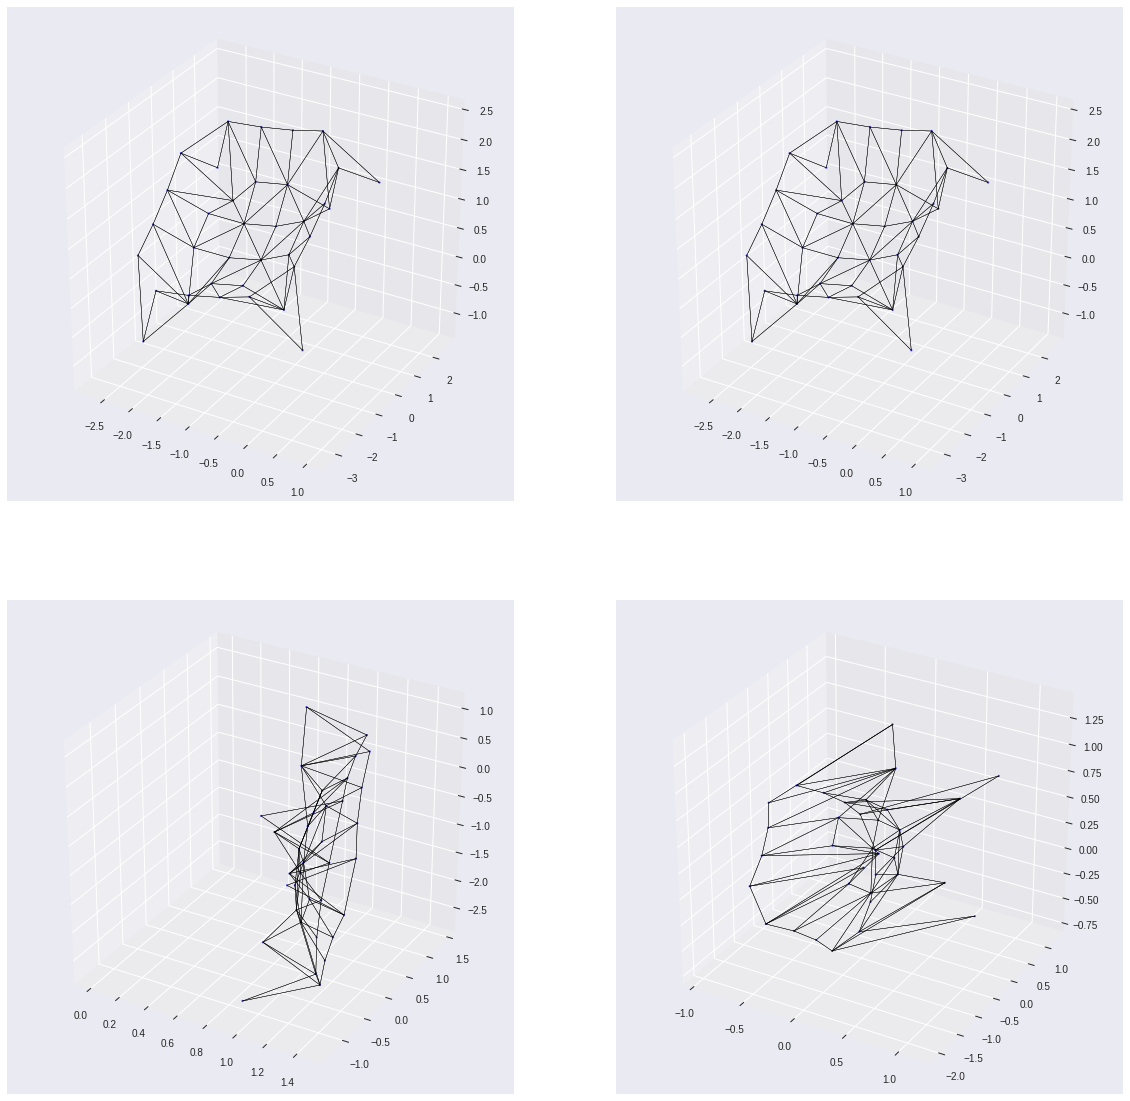

In [93]:
#@title #Visualize example graphs  { form-width: "30%" }
def rgb_from_hex(h):
    if h[0] != '#' or len(h) != 7:
        raise ValueError("'{}' should be '#' followed by 6 HEX chars".format(h))
    h = h.lstrip('#')
    h = h.upper()
    invalid_chars = set(list(h)) - set(list("0123456789ABCDEF"))
    if invalid_chars:
        raise ValueError("Incorrect chars: \{{}\}".format(', '.format(invalid_chars)))
    return tuple(int(h[i:i+2], 16)/255.0 for i in [0, 2 ,4])

#@markdown ##General Vizual Params

node_size=200 #@param{type:"slider", min:128, max:2048, step:1}
node_hex_color = "#808080" #@param {type:"string"}
node_color = rgb_from_hex(node_hex_color)
node_linewidth=1.0 #@param{type:"slider", min:0.1, max:3.0, step:0.1}
edge_width=0.2 #@param{type:"slider", min:0.1, max:3.0, step:0.1}
edge_style = "dashed" #@param ["solid", "dashed", "dotted", "dashdot"]
start_color="w"
end_color="k"

#@markdown ##Solution Vizual Paramters
solution_node_hex_color = "#3DFF3D" #@param {type:"string"}
solution_node_color = rgb_from_hex(solution_node_hex_color)
solution_node_linewidth=0.6 #@param{type:"slider", min:0.1, max:6.0, step:0.1}
solution_edge_width=6.0 #@param{type:"slider", min:0.1, max:4.0, step=0.1}
solution_edge_style = "solid" #@param ["solid", "dashed", "dotted", "dashdot"]


#@markdown ##Specific Parameters

seed = 5  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)

num_examples = 4  #@param{type: 'integer'}


min_nodes = 34 #@param {type:"slider", min:4, max:64, step:1}
max_nodes = 36 #@param {type:"slider", min:4, max:64, step:1}

theta = 12  #@param{type:"slider", min:4, max:64, step:1}
#@markdown Large values (1000+) make trees. Try 20-60 for good non-trees.

horizontal_length = 20 #@param{type: 'integer'}
graphs_per_column = 2 #@param{type: 'integer'}

min_max_nodes = (min_nodes, max_nodes)

graphs = generate_raw_graphs(
    rand,
    num_examples,
    min_max_nodes,
    theta
)

num = min(num_examples, 16)
size = horizontal_length/graphs_per_column
w = graphs_per_column
h = int(np.ceil(num / w))
fig = plt.figure(40, figsize=(w * size, h * size))
fig.clf()
for j, graph in enumerate(graphs):
    ax = fig.add_subplot(h, w, j + 1, projection='3d')
    points_coord_dict = nx.get_node_attributes(graph,'pos')
    points_coord = []
    for u in points_coord_dict:
        points_coord.append(points_coord_dict[len(points_coord)])
    points_coord = np.array(points_coord)                   
    print(points_coord)
    x = points_coord[:,0]
    y = points_coord[:,1]
    z = points_coord[:,2]

    list_edges = []
    #plot lines from edges
    for u,v in graph.edges:
        line = plt3d.art3d.Line3D(
            [x[u],x[v]], 
            [y[u],y[v]], 
            [z[u],z[v]], 
            linewidth=0.4, 
            c="black", 
            alpha=1.
        )
        ax.add_line(line)

    ax.scatter(x,y,z, marker='.', s=15, c="blue", alpha=0.6)


In [0]:
#@title Helper functions for setup training { form-width: "30%" }

def source_from_raw(raw):
    """Returns the graph with source feature vector for training.

    Args:
        raw: An `nx.DiGraph` instance.

    Returns:
        The source `nx.DiGraph` instance.

    Raises:
        ValueError: unknown node type
    """

    source = nx.DiGraph()
    # Nodes
    fields = ("weight", "solution")
    for node, feature in raw.nodes(data=True):
        source.add_node(
            node, features=create_feature(feature, fields)
        )
    # Edges
    fields = (DISTANCE_WEIGHT_NAME, "solution")
    for receiver, sender, feature in raw.edges(data=True):
        #print (feature)
        source.add_edge(
            sender, receiver, features=create_feature(feature, fields)
        )

    source.graph["features"] = np.array([0.0])

    return source

def target_from_raw(raw):
    """Returns the graph with target feature vector for training.

    Args:
        raw: An `nx.DiGraph` instance.

    Returns:
        The target `nx.DiGraph` instance.

    Raises:
        ValueError: unknown node type
    """

    target = nx.DiGraph()

    fields = ("solution",)
    solution_length = 0
    for node, feature in raw.nodes(data=True):
        target.add_node(node, features=to_one_hot(
            create_feature(feature, fields).astype(int), 2
        )[0])
        solution_length += int(feature["solution"])

    solution_length /= raw.number_of_nodes()

    for receiver, sender, feature in raw.edges(data=True):
        target.add_edge(sender, receiver, features=to_one_hot(
            create_feature(feature, fields).astype(int), 2
        )[0])

    target.graph["features"] = np.array([solution_length], dtype=float)

    return target

def generate_networkx_graphs(rand, num_examples, min_max_nodes, geo_density):
    """Generate graphs for training.

    Args:
        rand: A random seed (np.RandomState instance).
        num_examples: Total number of graphs to generate.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: (optional) A `float` threshold parameters for the geographic
            threshold graph's threshold. Default= the number of nodes.

    Returns:
        source_graphs: The list of source graphs.
        target_graphs: The list of output graphs.
        raw_graphs: The list of generated graphs.
    """
    raw_graphs = generate_raw_graphs(rand, num_examples, min_max_nodes, geo_density)
    source_graphs = [source_from_raw(raw) for raw in raw_graphs]
    target_graphs = [target_from_raw(raw) for raw in raw_graphs]

    return source_graphs, target_graphs, raw_graphs


# pylint: disable=redefined-outer-name
def create_placeholders(rand, batch_size, min_max_nodes, geo_density):
    """Creates placeholders for the model training and evaluation.

    Args:
        rand: A random seed (np.RandomState instance).
        batch_size: Total number of graphs per batch.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: A `float` threshold parameters for the geographic threshold graph's
            threshold. Default= the number of nodes.

    Returns:
        source_ph: The source graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.
    """
    # Create some example data for inspecting the vector sizes.
    raw_graphs = [
        generate_raw_graph(
            rand,
            min_max_nodes,
            geo_density=geo_density
        )
        for _ in range(batch_size)
    ]
    source_graphs = [source_from_raw(raw) for raw in raw_graphs]
    source_ph = utils_tf.placeholders_from_networkxs(
        source_graphs,
        force_dynamic_num_graphs=True
    )

    target_graphs = [target_from_raw(raw) for raw in raw_graphs]
    print_graphs(target_graphs)

    target_ph = utils_tf.placeholders_from_networkxs(
        target_graphs,
        force_dynamic_num_graphs=True
    )
    
    return source_ph, target_ph


def create_loss_ops(target_op, output_ops):
    loss_ops = [
        tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


In [0]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

tf.reset_default_graph()

seed = 2 
rand = np.random.RandomState(seed=seed)

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 10000
theta = 20  # Large values (1000+) make trees. Try 20-60 for good non-trees.
batch_size_tr = 32
batch_size_ge = 100
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (8, 17)
num_nodes_min_max_ge = (16, 33)

# Data.
# Input and target placeholders.
input_ph, target_ph = create_placeholders(
    rand,
    batch_size_tr,
    num_nodes_min_max_tr,
    theta
)

# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)




----------------------------------------------------------------------------
0 1 {'features': array([1., 0.])} (ok)
0 2 {'features': array([1., 0.])} (ok)
0 3 {'features': array([1., 0.])} (ok)
0 10 {'features': array([1., 0.])} (ok)
0 13 {'features': array([1., 0.])} (ok)
0 14 {'features': array([1., 0.])} (ok)
0 15 {'features': array([0., 1.])} (ok)
1 0 {'features': array([0., 1.])} (ok)
1 2 {'features': array([1., 0.])} (ok)
1 3 {'features': array([1., 0.])} (ok)
1 4 {'features': array([1., 0.])} (ok)
1 5 {'features': array([1., 0.])} (ok)
1 6 {'features': array([1., 0.])} (ok)
1 7 {'features': array([1., 0.])} (ok)
1 8 {'features': array([1., 0.])} (ok)
1 9 {'features': array([1., 0.])} (ok)
1 10 {'features': array([1., 0.])} (ok)
1 11 {'features': array([1., 0.])} (ok)
1 12 {'features': array([1., 0.])} (ok)
1 13 {'features': array([1., 0.])} (ok)
1 14 {'features': array([1., 0.])} (ok)
1 15 {'features': array([1., 0.])} (ok)
2 0 {'features': array([1., 0.])} (ok)
2 1 {'features':

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [0]:
#@title Helper functions for training { form-width: "30%" }

# pylint: disable=redefined-outer-name
def create_feed_dict(
    rand,
    batch_size,
    min_max_nodes,
    geo_density,
    source_ph,
    target_ph
):
    """Creates placeholders for the model training and evaluation.

    Args:
        rand: A random seed (np.RandomState instance).
        batch_size: Total number of graphs per batch.
        min_max_nodes: A 2-tuple with the [lower, upper) number of nodes per
            graph. The number of nodes for a graph is uniformly sampled within this
            range.
        geo_density: A `float` threshold parameters for the geographic threshold graph's
            threshold. Default= the number of nodes.
        source_ph: The source graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.

    Returns:
        feed_dict: The feed `dict` of source and target placeholders and data.
        raw_graphs: The `dict` of raw networkx graphs.
    """
    sources, targets, raw_graphs = generate_networkx_graphs(
        rand,
        batch_size,
        min_max_nodes,
        geo_density
    )
    source_graphs = utils_np.networkxs_to_graphs_tuple(sources)
    target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
    feed_dict = {
        source_ph: source_graphs, 
        target_ph: target_graphs
    }
    return feed_dict, raw_graphs

def compute_accuracy(target, output, use_nodes=False, use_edges=True):
    """Calculate model accuracy.

    Returns the number of correctly predicted shortest path nodes and the number
    of completely solved graphs (100% correct predictions).

    Args:
        target: A `graphs.GraphsTuple` that contains the target graph.
        output: A `graphs.GraphsTuple` that contains the output graph.
        use_nodes: A `bool` indicator of whether to compute node accuracy or not.
        use_edges: A `bool` indicator of whether to compute edge accuracy or not.

    Returns:
        correct: A `float` fraction of correctly labeled nodes/edges.
        solved: A `float` fraction of graphs that are completely correctly labeled.

    Raises:
        ValueError: Nodes or edges (or both) must be used
    """
    if not use_nodes and not use_edges:
        raise ValueError("Nodes or edges (or both) must be used")
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)
        xe = np.argmax(td["edges"], axis=-1)
        ye = np.argmax(od["edges"], axis=-1)
        c = []
        if use_nodes:
            c.append(xn == yn)
        if use_edges:
            c.append(xe == ye)
        c = np.concatenate(c, axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))
    return correct, solved

In [0]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
            "Ltr (training loss), Lge (test/generalization loss), "
            "Ctr (training fraction nodes/edges labeled correctly), "
            "Str (training fraction examples solved correctly), "
            "Cge (test/generalization fraction nodes/edges labeled correctly), "
            "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    feed_dict, _ = create_feed_dict(
        rand,
        batch_size_tr,
        num_nodes_min_max_tr,
        theta,
        input_ph,
        target_ph
    )
    train_values = sess.run(
        {
            "step": step_op,
            "target": target_ph,
            "loss": loss_op_tr,
            "outputs": output_ops_tr
        },
        feed_dict=feed_dict
    )
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        feed_dict, raw_graphs = create_feed_dict(
                rand, batch_size_ge, num_nodes_min_max_ge, theta, input_ph, target_ph)
        test_values = sess.run(
            {
                "target": target_ph,
                "loss": loss_op_ge,
                "outputs": output_ops_ge
            },
            feed_dict=feed_dict
        )
        correct_tr, solved_tr = compute_accuracy(
            train_values["target"],
            train_values["outputs"][-1],
            use_edges=True
        )
        correct_ge, solved_ge = compute_accuracy(
            test_values["target"],
            test_values["outputs"][-1],
            use_edges=True
        )
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        losses_ge.append(test_values["loss"])
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        logged_iterations.append(iteration)
        print(
            "# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, Str"
            " {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
                iteration, elapsed, train_values["loss"], test_values["loss"],
                correct_tr, solved_tr, correct_ge, solved_ge
            )
        )


# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00025, T 24.8, Ltr 0.1450, Lge 0.0832, Ctr 0.9370, Str 0.0000, Cge 0.9815, Sge 0.0000
# 00058, T 43.7, Ltr 0.0355, Lge 0.0269, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00095, T 64.2, Ltr 0.0169, Lge 0.0140, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00130, T 84.1, Ltr 0.0108, Lge 0.0094, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00166, T 104.2, Ltr 0.0080, Lge 0.0070, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00203, T 124.5, Ltr 0.0062, Lge 0.0054, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00239, T 144.5, Ltr 0.0049, Lge 0.0042, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 00277, T 165.0, Ltr 0.0039, Lge 0.0034, Ctr 1.0000

In [0]:
#@title Visualize results  { form-width: "30%" }

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def softmax_prob_last_dim(x):  # pylint: disable=redefined-outer-name
    e = np.exp(x)
    return e[:, -1] / np.sum(e, axis=-1)


# Plot results curves.
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot graphs and results after each processing step.
# The white node is the start, and the black is the end. Other nodes are colored
# from red to purple to blue, where red means the model is confident the node is
# off the shortest path, blue means the model is confident the node is on the
# shortest path, and purplish colors mean the model isn't sure.
max_graphs_to_plot = 8 #@param{type:"slider", min:4, max:8, step:1}
num_steps_to_plot = 4 #@param{type:"slider", min:1, max:8, step:1}
node_size = 120 #@param{type:"slider", min:64, max:2048, step:1}
min_c = 0.3
num_graphs = len(raw_graphs)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
step_indices = np.floor(
    np.linspace(
        0, num_processing_steps_ge - 1,
        num_steps_to_plot
    )
).astype(int).tolist()

outputs = list(zip(*(
    utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
    for i in step_indices
)))
h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (graph, target, output) in enumerate(zip(raw_graphs, targets, outputs)):
    if j >= h:
        break
    ground_truth = target["nodes"][:, -1]
    # Ground truth.
    iax = j * (1 + num_steps_to_plot) + 1
    ax = fig.add_subplot(h, w, iax)
    plotter = GraphPlotter(ax, graph)
    color = {}
    for i, n in enumerate(plotter.nodes):
        color[n] = np.array(
            [1.0 - ground_truth[i], 0.0, ground_truth[i], 1.0]
        ) * (1.0 - min_c) + min_c
    plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
    ax.set_axis_on()
    ax.set_xticks([])
    ax.set_yticks([])
    try:
        ax.set_facecolor([0.9] * 3 + [1.0])
    except AttributeError:
        ax.set_axis_bgcolor([0.9] * 3 + [1.0])
    ax.grid(None)
    ax.set_title(
        "Ground truth\nSolution length: {}"
            .format(plotter.solution_length)
    )
    # Prediction.
    for k, outp in enumerate(output):
        iax = j * (1 + num_steps_to_plot) + 2 + k
        ax = fig.add_subplot(h, w, iax)
        plotter = GraphPlotter(ax, graph)
        color = {}
        prob = softmax_prob_last_dim(outp["nodes"])
        for i, n in enumerate(plotter.nodes):
            color[n] = np.array(
                [1.0 - prob[n], 0.0, prob[n], 1.0]
            ) * (1.0 - min_c) + min_c
        plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
        ax.set_title(
            "Model-predicted\nStep {:02d} / {:02d}".format(
                step_indices[k] + 1,
                step_indices[-1] + 1
            )
        )